Iniciando pipeline de Machine Learning...
Index(['relative_humidity_2m', 'apparent_temperature', 'precipitation', 'rain',
       'weather_code', 'cloud_cover', 'wind_direction_10m', 'wind_speed_10m',
       'is_day', 'wind_speed_6h_mean', 'precipitation_6h_mean',
       'temperature_6h_mean'],
      dtype='object')
Treinando o modelo: Random Forest
Validação cruzada (Random Forest): R² médio = 0.9980 (+/- 0.0001)
Random Forest - MAE: 0.0980, MSE: 0.0289, RMSE: 0.1700, R2: 0.9981
Treinando o modelo: Gradient Boosting
Validação cruzada (Gradient Boosting): R² médio = 0.9950 (+/- 0.0003)
Gradient Boosting - MAE: 0.1829, MSE: 0.0739, RMSE: 0.2719, R2: 0.9952
Treinando o modelo: XGBoost
Validação cruzada (XGBoost): R² médio = 0.9978 (+/- 0.0001)
XGBoost - MAE: 0.1170, MSE: 0.0326, RMSE: 0.1807, R2: 0.9979
Treinando o modelo: LightGBM
[LightGBM] [Info] Total Bins 2082
[LightGBM] [Info] Number of data points in the train set: 28062, number of used features: 12
[LightGBM] [Info] Start training

<Figure size 1200x600 with 0 Axes>

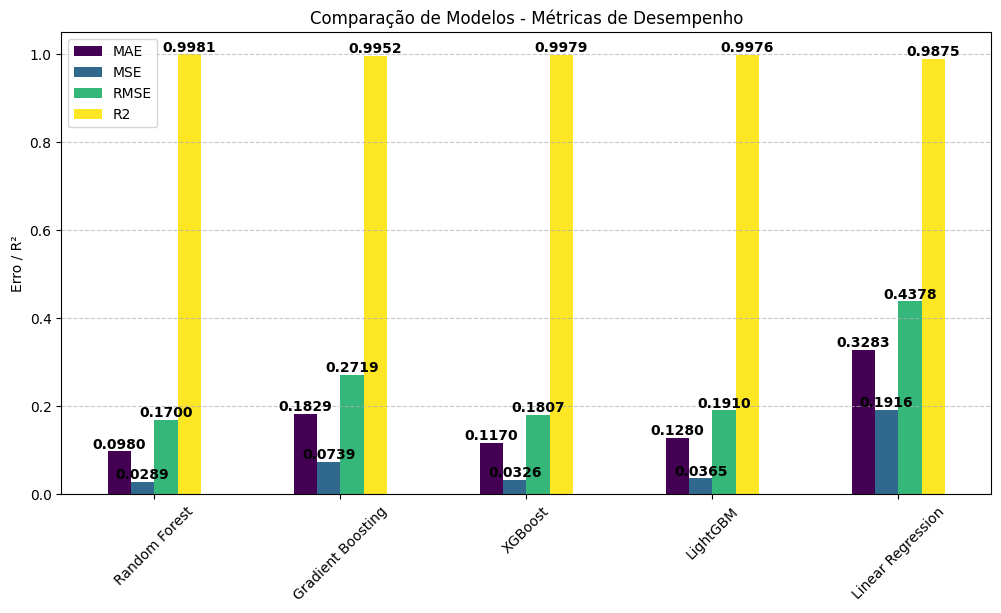

Melhor modelo salvo: best_model_Random Forest.pkl
Execução finalizada em 132.25 segundos.


In [1]:
import pandas as pd
import numpy as np
import time
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import lightgbm as lgb

def load_and_preprocess_data(file_path: str) -> tuple[pd.DataFrame, pd.Series]:
    """
    Carrega e processa os dados para modelagem de Machine Learning.

    Parâmetros:
    -----------
    file_path : str
        Caminho para o arquivo CSV.

    Retorno:
    --------
    X : pd.DataFrame
        Variáveis independentes.
    y : pd.Series
        Variável alvo (temperatura_2m).
    """
    df = pd.read_csv(file_path, sep=";")
    
    # Verificar e tratar valores ausentes
    df = df.dropna()
    
    # Converter colunas de data
    df['date'] = pd.to_datetime(df['date'])
    
    # Separar features e target
    X = df.drop(columns=["temperature_2m", "date"])
    y = df["temperature_2m"]
    print(X.columns)
    
    return X, y

def evaluate_models(X: pd.DataFrame, y: pd.Series) -> tuple[dict, str]:
    """
    Treina e avalia modelos de regressão, aplicando validação cruzada e GridSearch.

    Parâmetros:
    -----------
    X : pd.DataFrame
        Features de entrada.
    y : pd.Series
        Target.

    Retorno:
    --------
    results : dict
        Dicionário com métricas de desempenho dos modelos.
    best_model_name : str
        Nome do melhor modelo baseado no R².
    """
    models = {
        "Random Forest": RandomForestRegressor(),
        "Gradient Boosting": GradientBoostingRegressor(),
        "XGBoost": xgb.XGBRegressor(),
        "LightGBM": lgb.LGBMRegressor(force_row_wise=True),
        "Linear Regression": LinearRegression()
    }

    param_grid = {
        "Random Forest": {"n_estimators": [50, 100], "max_depth": [None, 10]},
        "Gradient Boosting": {"n_estimators": [50, 100], "learning_rate": [0.05, 0.1]},
        "XGBoost": {"n_estimators": [50, 100], "learning_rate": [0.05, 0.1]},
        "LightGBM": {"n_estimators": [50, 100], "learning_rate": [0.05, 0.1]},
        "Linear Regression": {}
    }

    results = {}
    best_model = None
    best_r2 = -np.inf
    best_model_name = ""

    # Divisão treino/teste
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    for model_name, model in models.items():
        print(f"Treinando o modelo: {model_name}")

        # Aplicar Scaling para modelos sensíveis à escala
        if model_name in ["Linear Regression", "Gradient Boosting", "XGBoost"]:
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
        else:
            X_train_scaled = X_train
            X_test_scaled = X_test

        # Validação cruzada
        cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='r2')
        print(f"Validação cruzada ({model_name}): R² médio = {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

        # GridSearch para otimização de hiperparâmetros
        grid = GridSearchCV(model, param_grid[model_name], cv=3, scoring="r2", n_jobs=-1)
        grid.fit(X_train_scaled, y_train)
        best_model_instance = grid.best_estimator_

        # Predições
        y_pred = best_model_instance.predict(X_test_scaled)

        # Cálculo de métricas
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)

        results[model_name] = {
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R2": r2,
            "CrossVal_R2_Mean": cv_scores.mean(),
            "CrossVal_R2_Std": cv_scores.std()
        }

        print(f"{model_name} - MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}")

        # Atualizar melhor modelo
        if r2 > best_r2:
            best_r2 = r2
            best_model = best_model_instance
            best_model_name = model_name

    return results, best_model_name, best_model

def plot_results(results: dict):
    """
    Plota gráficos comparativos das métricas dos modelos com valores nas colunas.

    Parâmetros:
    -----------
    results : dict
        Dicionário contendo as métricas dos modelos.
    """
    df_results = pd.DataFrame(results).T
    metrics = ['MAE', 'MSE', 'RMSE', 'R2']
    
    plt.figure(figsize=(12, 6))
    ax = df_results[metrics].plot(kind='bar', figsize=(12, 6), colormap='viridis')
    
    plt.title("Comparação de Modelos - Métricas de Desempenho")
    plt.ylabel("Erro / R²")
    plt.xticks(rotation=45)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    
    # Adicionando valores no topo de cada barra
    for p in ax.patches:
        ax.annotate(
            f"{p.get_height():.4f}",  # Formata o valor com 4 casas decimais
            (p.get_x() + p.get_width() / 2, p.get_height()),  # Posição no gráfico
            ha='center', va='bottom', fontsize=10, fontweight="bold", color="black"
        )

    plt.show()

def save_best_model(best_model, best_model_name: str):
    """
    Salva o melhor modelo treinado para uso em produção.

    Parâmetros:
    -----------
    best_model : estimador do sklearn
        Modelo de ML treinado.
    best_model_name : str
        Nome do melhor modelo.
    """
    joblib.dump(best_model, f"best_model_{best_model_name}.pkl")
    print(f"Melhor modelo salvo: best_model_{best_model_name}.pkl")

def main(file_path: str):
    """
    Função principal para carregar dados, treinar modelos e selecionar o melhor.

    Parâmetros:
    -----------
    file_path : str
        Caminho do dataset CSV.
    """
    start_time = time.time()
    print("Iniciando pipeline de Machine Learning...")

    # Carregar e processar os dados
    X, y = load_and_preprocess_data(file_path)

    # Treinar e avaliar modelos
    results, best_model_name, best_model = evaluate_models(X, y)

    # Plotar resultados
    plot_results(results)

    # Salvar o melhor modelo
    save_best_model(best_model, best_model_name)

    end_time = time.time()
    duration = end_time - start_time
    print(f"Execução finalizada em {duration:.2f} segundos.")

# Execução
if __name__ == "__main__":
    file_path = "./data/historical_data_new_features.csv"
    main(file_path)
